In [33]:
from src.database_config.database import session
from src.models.base import Base
from src.models.articles import Article
from src.models.prices import Price
from src.models.prices_latest import PriceLatest
from src.models.stores import Store
from src.models.categories import Category
from src.models.images import Image
from sqlalchemy.orm import joinedload
from sqlalchemy import func

## 10 Najdražjih Izdelkov

In [7]:
from sqlalchemy import desc

expensive = (
    session.query(Article, PriceLatest.price)
    .join(PriceLatest, Article.id == PriceLatest.article_id)
    .order_by(desc(PriceLatest.price))
    .limit(10)
    .all()
)

for article, price in expensive:
    print(f"{article.name:30} | {price}")


2025-10-31 18:34:25,641 INFO sqlalchemy.engine.Engine SELECT articles.id AS articles_id, articles.ean_13 AS articles_ean_13, articles.name AS articles_name, articles.brand_name AS articles_brand_name, articles.invoice_unit AS articles_invoice_unit, articles.invoice_unit_type AS articles_invoice_unit_type, articles.store_id AS articles_store_id, prices_latest.price AS prices_latest_price 
FROM articles JOIN prices_latest ON articles.id = prices_latest.article_id ORDER BY prices_latest.price DESC 
 LIMIT %(param_1)s
2025-10-31 18:34:25,645 INFO sqlalchemy.engine.Engine [generated in 0.00355s] {'param_1': 10}
Okrogel bazen, Avenli, 450 x 122 cm | 239.99
Parni čistilec tal, Steam Plus, Vileda | 189.99
Stojalo za sušenje perila, King, Vileda | 74.99
Set za čiščenje tal, Turbo Mop, Vileda | 65.99
Talni čistilec, Vileda 1.2. Spray Max | 57.29
Set Ultramax Box, Vileda       | 51.99
Cvrtnik na vroži zrak Delight, Delimano | 47.99
Škotski Whiskey, Chivas Regal, 40 % alkohola, 1 l | 43.19
Škotski

## Slike Izdelkov

2025-10-31 18:41:23,222 INFO sqlalchemy.engine.Engine SELECT articles.id AS articles_id, articles.ean_13 AS articles_ean_13, articles.name AS articles_name, articles.brand_name AS articles_brand_name, articles.invoice_unit AS articles_invoice_unit, articles.invoice_unit_type AS articles_invoice_unit_type, articles.store_id AS articles_store_id, images.id AS images_id, images.article_id AS images_article_id, images.image AS images_image 
FROM articles JOIN images ON articles.id = images.article_id 
WHERE articles.name ILIKE %(name_1)s 
 LIMIT %(param_1)s
2025-10-31 18:41:23,225 INFO sqlalchemy.engine.Engine [cached since 160.7s ago] {'name_1': '%bonbon%', 'param_1': 3}
Article: Sadni jogurt Oki Doki vanilija s pisanimi čokoladnimi bonboni, Zelene Doline, 150 g


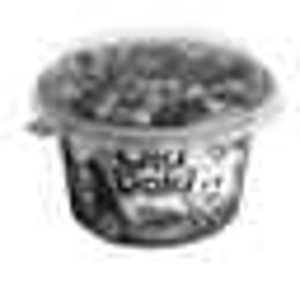

Article: Bonboniera Lindor mešane kroglice, Lindt, 200 g


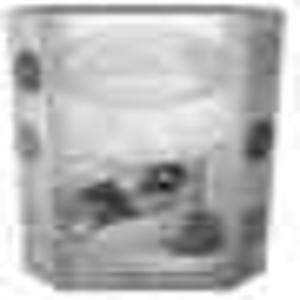

Article: Bonboni Fruit Jelly, Šumi, 400 g


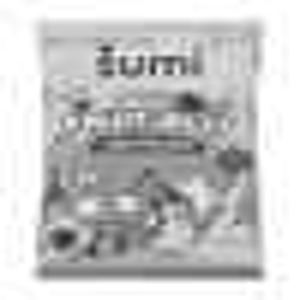

In [ ]:
from PIL import Image as PILImage
import io
from IPython.display import display

def show_article_images(name_like: str, n: int = 5, display_size: tuple[int,int]=(200,200)):
    """
    Show up to n images for articles whose name contains name_like.
    
    :param name_like: substring to search in article names
    :param n: maximum number of images to display
    :param display_size: (width, height) to resize images for display
    """
    results = (
        session.query(Article, Image)
        .join(Image, Article.id == Image.article_id)
        .filter(Article.name.ilike(f"%{name_like}%"))
        .limit(n)
        .all()
    )
    if not results:
        print(f"No articles found with name containing '{name_like}'.")
        return
    for article, img_record in results:
        print(f"Article: {article.name}")
        if img_record and img_record.image:
            pil_img = PILImage.open(io.BytesIO(img_record.image))
            # Resize for display only
            pil_img_resized = pil_img.resize(display_size)
            display(pil_img_resized)
        else:
            print("No image available for this article.")

# Example usage: show up to 3 images with 300x300 display size
show_article_images(name_like="bonbon", n=3, display_size=(300,300))

## Gibanje Cen

2025-10-31 18:52:59,461 INFO sqlalchemy.engine.Engine SELECT articles.id AS articles_id, articles.ean_13 AS articles_ean_13, articles.name AS articles_name, articles.brand_name AS articles_brand_name, articles.invoice_unit AS articles_invoice_unit, articles.invoice_unit_type AS articles_invoice_unit_type, articles.store_id AS articles_store_id, count(prices.id) AS price_count 
FROM articles JOIN prices ON articles.id = prices.article_id GROUP BY articles.id ORDER BY count(prices.id) DESC 
 LIMIT %(param_1)s
2025-10-31 18:52:59,465 INFO sqlalchemy.engine.Engine [cached since 237.3s ago] {'param_1': 3}


Article: Kocke za podžig, Home, 48/1 (4 prices)
2025-10-31 18:52:59,537 INFO sqlalchemy.engine.Engine SELECT prices.id AS prices_id, prices.article_id AS prices_article_id, prices.price AS prices_price, prices.price_per_unit AS prices_price_per_unit, prices.price_per_unit_base AS prices_price_per_unit_base, prices.timestamp AS prices_timestamp 
FROM prices 
WHERE prices.article_id = %(article_id_1)s ORDER BY prices.timestamp
2025-10-31 18:52:59,538 INFO sqlalchemy.engine.Engine [cached since 237.3s ago] {'article_id_1': 1885}
Article: Pivo, Mercator, 4,0 % alkohola, 0,5 l (4 prices)
2025-10-31 18:52:59,561 INFO sqlalchemy.engine.Engine SELECT prices.id AS prices_id, prices.article_id AS prices_article_id, prices.price AS prices_price, prices.price_per_unit AS prices_price_per_unit, prices.price_per_unit_base AS prices_price_per_unit_base, prices.timestamp AS prices_timestamp 
FROM prices 
WHERE prices.article_id = %(article_id_1)s ORDER BY prices.timestamp
2025-10-31 18:52:59,562 INFO 

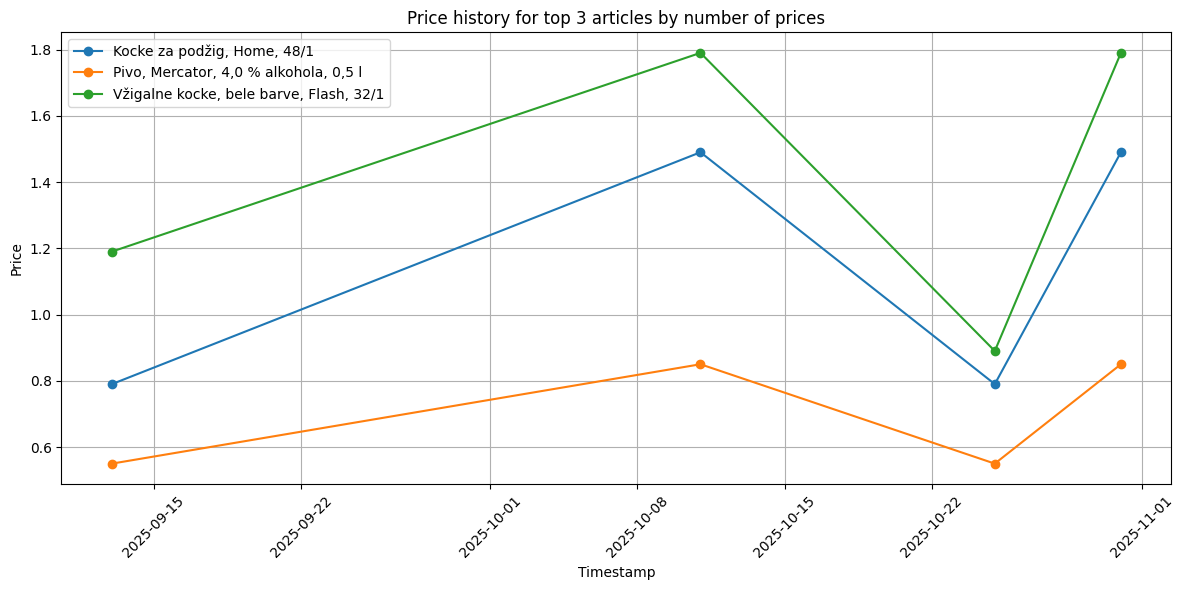

In [20]:
import matplotlib.pyplot as plt

def plot_top_articles_price_history(n: int = 3) -> None:
    """
    Plots price history for top n articles with the most price entries.

    :param n: number of articles to plot
    """
    # Step 1: Get top n articles by price count
    top_articles = (
        session.query(Article, func.count(Price.id).label("price_count"))
        .join(Price, Article.id == Price.article_id)
        .group_by(Article.id)
        .order_by(func.count(Price.id).desc())
        .limit(n)
        .all()
    )
    if not top_articles:
        print("No articles with prices found.")
        return
    plt.figure(figsize=(12,6))
    # Step 2: Plot each article
    for article, price_count in top_articles:
        print(f"Article: {article.name} ({price_count} prices)")
        price_history = (
            session.query(Price)
            .filter(Price.article_id == article.id)
            .order_by(Price.timestamp)
            .all()
        )
        if not price_history:
            print(f"No price history available for article '{article.name}'.")
            continue
        timestamps= [p.timestamp for p in price_history]
        prices= [float(p.price) for p in price_history]
        plt.plot(timestamps, prices, marker='o', linestyle='-', label=article.name) # type: ignore
    # Step 3: Finalize plot
    plt.title(f"Price history for top {n} articles by number of prices")
    plt.xlabel("Timestamp")
    plt.ylabel("Price")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage: plot top 3 articles
plot_top_articles_price_history(n=3)

## Volatilnost Izdelkov

2025-10-31 18:55:02,563 INFO sqlalchemy.engine.Engine SELECT prices.article_id AS prices_article_id, max(prices.price) - min(prices.price) AS anon_1 
FROM prices GROUP BY prices.article_id ORDER BY max(prices.price) - min(prices.price) DESC 
 LIMIT %(param_1)s
2025-10-31 18:55:02,568 INFO sqlalchemy.engine.Engine [generated in 0.00499s] {'param_1': 5}
2025-10-31 18:55:02,655 INFO sqlalchemy.engine.Engine SELECT prices.id AS prices_id, prices.article_id AS prices_article_id, prices.price AS prices_price, prices.price_per_unit AS prices_price_per_unit, prices.price_per_unit_base AS prices_price_per_unit_base, prices.timestamp AS prices_timestamp 
FROM prices 
WHERE prices.article_id = %(article_id_1)s ORDER BY prices.timestamp
2025-10-31 18:55:02,658 INFO sqlalchemy.engine.Engine [cached since 360.5s ago] {'article_id_1': 7636}


2025-10-31 18:55:02,717 INFO sqlalchemy.engine.Engine SELECT prices.id AS prices_id, prices.article_id AS prices_article_id, prices.price AS prices_price, prices.price_per_unit AS prices_price_per_unit, prices.price_per_unit_base AS prices_price_per_unit_base, prices.timestamp AS prices_timestamp 
FROM prices 
WHERE prices.article_id = %(article_id_1)s ORDER BY prices.timestamp
2025-10-31 18:55:02,720 INFO sqlalchemy.engine.Engine [cached since 360.5s ago] {'article_id_1': 6604}
2025-10-31 18:55:02,733 INFO sqlalchemy.engine.Engine SELECT prices.id AS prices_id, prices.article_id AS prices_article_id, prices.price AS prices_price, prices.price_per_unit AS prices_price_per_unit, prices.price_per_unit_base AS prices_price_per_unit_base, prices.timestamp AS prices_timestamp 
FROM prices 
WHERE prices.article_id = %(article_id_1)s ORDER BY prices.timestamp
2025-10-31 18:55:02,738 INFO sqlalchemy.engine.Engine [cached since 360.5s ago] {'article_id_1': 10994}
2025-10-31 18:55:02,750 INFO sq

/tmp/ipykernel_12138/2368945720.py:21: LegacyAPIWarning: The Query.get() method is considered legacy as of the 1.x series of SQLAlchemy and becomes a legacy construct in 2.0. The method is now available as Session.get() (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  article = session.query(Article).get(article_id)


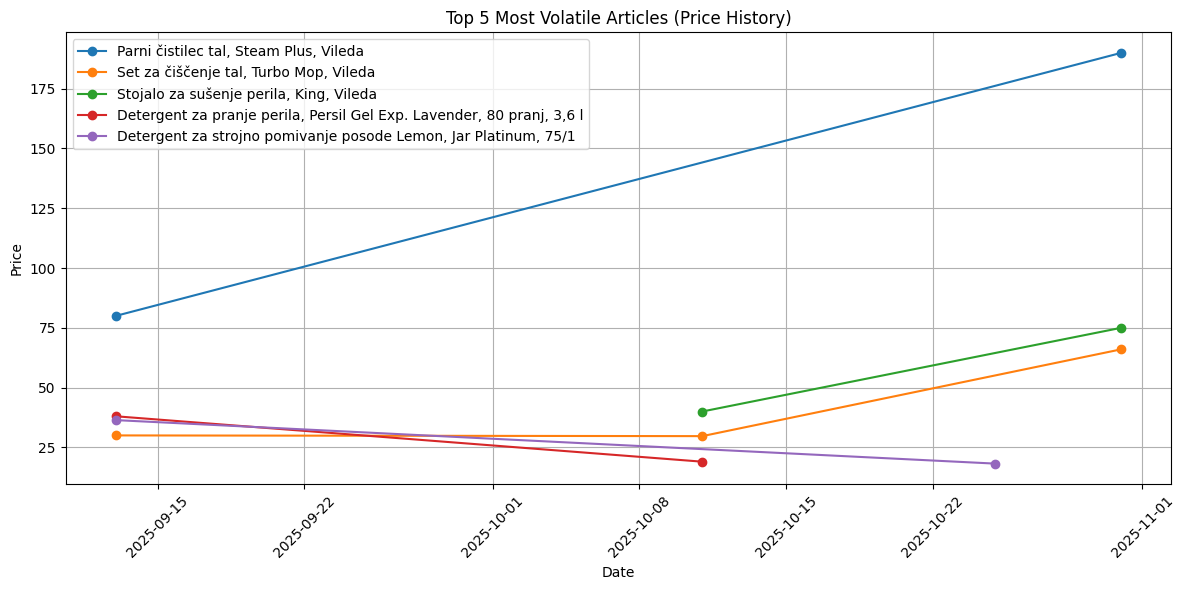

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Find top 5 most volatile articles (max price - min price)
top_volatile_articles = (
    session.query(
        Price.article_id,
        func.max(Price.price) - func.min(Price.price)
    )
    .group_by(Price.article_id)
    .order_by((func.max(Price.price) - func.min(Price.price)).desc())
    .limit(5)
    .all()
)

if not top_volatile_articles:
    print("No price data available.")
else:
    plt.figure(figsize=(12,6))

    for article_id, _ in top_volatile_articles:
        article = session.query(Article).get(article_id)
        price_history = (
            session.query(Price)
            .filter(Price.article_id == article_id)
            .order_by(Price.timestamp)
            .all()
        )
        timestamps = [p.timestamp for p in price_history]
        prices = [float(p.price) for p in price_history]

        plt.plot(timestamps, prices, marker='o', linestyle='-', label=article.name) # type: ignore

    plt.title("Top 5 Most Volatile Articles (Price History)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Plain Table

In [ ]:
import pandas as pd
from sqlalchemy import select

# Step 1: Construct a left join query
stmt = (
    select(
        Article.id,
        Article.name,
        Article.brand_name,
        PriceLatest.price,
        PriceLatest.timestamp
    )
    .outerjoin(PriceLatest, Article.id == PriceLatest.article_id)
)

# Step 2: Read into Pandas DataFrame
df = pd.read_sql(stmt, session.bind)  # type: ignore

# Step 3: Show first 5 rows
df.head()

2025-10-31 19:02:39,975 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-10-31 19:02:39,978 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-10-31 19:02:39,980 INFO sqlalchemy.engine.Engine [cached since 225.9s ago] {'table_name': <sqlalchemy.sql.selectable.Select object at 0x7712c8bd3b60>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2025-10-31 19:02:39,983 INFO sqlalchemy.engine.Engine SELECT articles.id, articles.name, articles.brand_name, prices_latest.price, prices_latest.timestamp 
FROM articles LEFT OUTER

,id,name,brand_name,price,timestamp
0,9290,"Pogrinjek, zelen, 36 cm",TZ–EKSKLUZIVNI BRAND,1.49,2025-09-13
1,3200,"Balzam za ustnice, spf4, Neutrogena",NEUTROGENA,3.49,2025-09-13
2,10022,"Lesena kuhalnica, 40cm",KGZ RIBNICA,1.49,2025-09-13
3,10185,"Nož za zrezke, velikosti 12,7 cm",HOME,4.99,2025-09-13
4,2,"Temne bučke, cena za kg",S&Z BREZ BZ,0.99,2025-09-13
